# This code is for finding the floquet exponents from the distance of the limit cycle

In [1]:
import numpy as np
import matplotlib
import imageio.v2 as imageio
from IPython.display import Image
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy as sm
from sympy import symbols, Matrix
import os
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree
from scipy.interpolate import splprep, splev
matplotlib.use('TkAgg')  # or 'Qt5Agg'
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 12]
L = 4
x = np.linspace(0.01,L,500)
y = np.linspace(0.01,L,500)
X,Y = np.meshgrid(x,y)



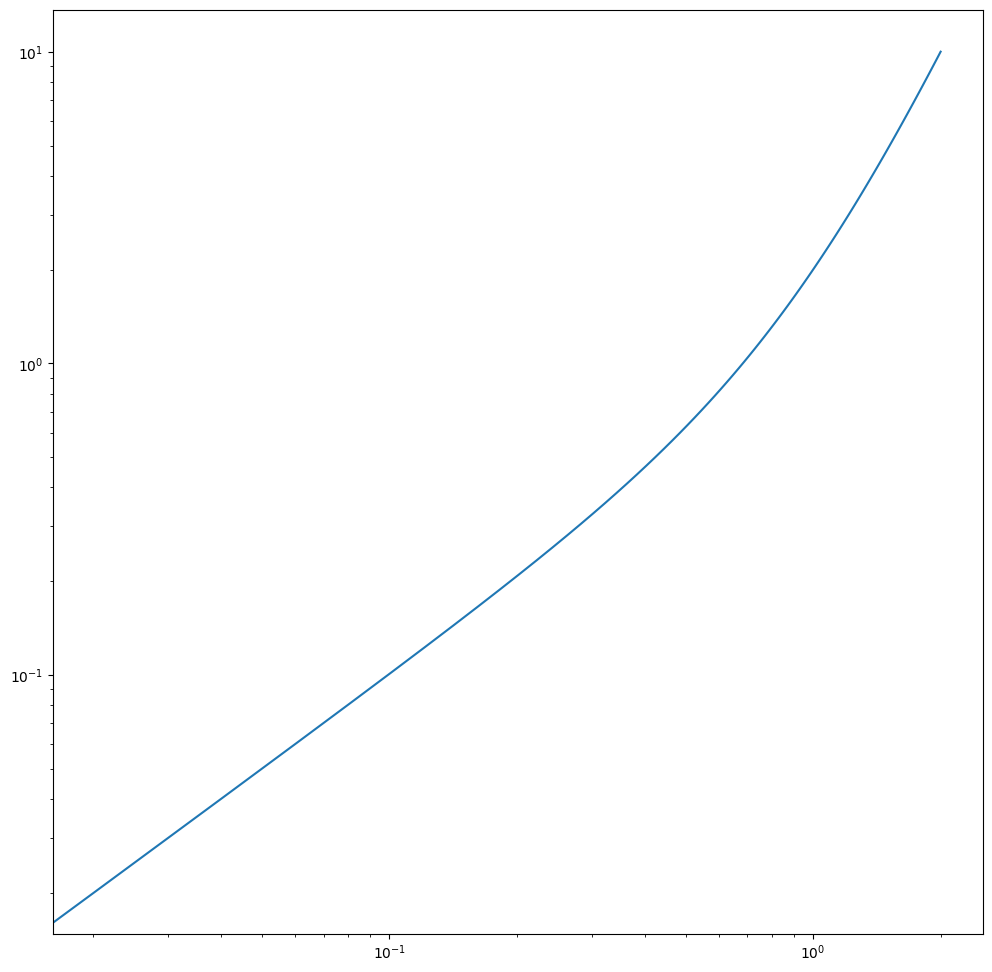

In [6]:
x = np.linspace(0,2,100)
plt.plot(x,x**3+x)
plt.yscale('log')
plt.xscale('log')

## Functions and definitions:

In [2]:
#Selkov model for glycolysis

def nullcline_x(x,a = 0.1):
    return x/(a + x**2)
    
def nullcline_y(x,b,a = 0.1):
    return b/(a+ x**2)

def SelkovX(x,y,b,a = 0.1):
    return -x + a*y + x**2*y

def SelkovY(x,y,b,a = 0.1):
    return b - a*y - x**2*y


#Supercritical hopf bifurcation
def x_supercrit(x,y,mu,w = 1):
    return (mu-x**2-y**2)*x-w*y #normalformen for superkritiske hopf.
def y_supercrit(x,y,mu,w = 1):
    return (mu-x**2-y**2)*y+w*x

#Solutions to the supercritcal hopf bifurcation
def solution_supercrit_Pol(t,mu,w,r0): #Polar coordinates
    C = (r0**2-mu)/(r0**2)
    T = 2*mu*t
    return (mu/(1-C*np.exp(-T)))**0.5

def solution_supercritTheta(t,w,theta0): #Theta, lidt ligegyldig
    return w*t +theta0

def solution_supercrit_Cart(t, mu,w, x0, y0): #Cartesian coordinates
    #theta = np.arctan2(y0,x0)
    return np.cos(w*t)*solution_supercrit_Pol(t, mu, w, x0), np.sin(w*t)*solution_supercrit_Pol(t, mu, w, y0) #x(t) and y(t)


#Van Der Pol

def VanX(x,y,mu,w):
    return y
def VanY(x,y,mu,w):
    return mu*(1-x**2)*y-x

#Other stuff
def linfit(x,a,b):
    return a*x+b
def quadfit(x,a,b,c):
    return a*x**2+b*x+c
def cubicfit(x,a,b,c,d):
    return a*x**3+b*x**2+c*x+d

def fit(t, b, a):
    return a * np.e**(b*t)

In [3]:

#RK-4 integrator
def intgrator_rk4(func_x,func_y,dt,x,y,paramsx,paramsy): #Input function, timestep, coordinates and finally params as [...,...,...]
    
    k1x = func_x(x,y,*paramsx)*dt
    k1y = func_y(x,y,*paramsy)*dt
    
    k2x = func_x(x+0.5*k1x, y+0.5*k1y, *paramsx)*dt
    k2y = func_y(x+0.5*k1x, y+0.5*k1y, *paramsy)*dt
    
    k3x = func_x(x+0.5*k2x, y+0.5*k2y, *paramsx)*dt
    k3y = func_y(x+0.5*k2x, y+0.5*k2y, *paramsy)*dt
    
    k4x = func_x(x+k3x,y+k3y, *paramsx)*dt
    k4y = func_y(x+k3x,y+k3y, *paramsy)*dt
    
    xnew = x + 1./6*(k1x+2*k2x+2*k3x+k4x)
    ynew = y + 1./6*(k1y+2*k2y+2*k3y+k4y)

    return xnew, ynew


def calculate_distance_to_limit_cycle(trajectory, limit_cycle_x, limit_cycle_y):
    # Create a KDTree for limit cycle points, speeds up instead of using values directly.
    limit_cycle_points = np.vstack((limit_cycle_x, limit_cycle_y)).T
    kdtree = cKDTree(limit_cycle_points)
    
    #distances = []
    trajectory_points = np.vstack((trajectory[0], trajectory[1])).T
    distances, _ = kdtree.query(trajectory_points)
    if len(distances) == 1:
        return distances[0]
        #return distances
    return distances


def poincare_slice(x,y,limx,limy,functionx,mu,npoints,dt):
    distancenewlist = []
    timespace = []
    index  = np.array(limx).argmin()
    if functionx == SelkovX:
        prev_sign = np.sign(y[0] - limy[index]) # Compare x[0] with mu for the initial sign
        for i, (X,Y) in enumerate(zip(x,y)):  
            current_sign = np.sign(Y - limy[index])  # Compare current X with mu
            if prev_sign < 0 and current_sign >= 0 or i==0:#current_sign != prev_sign:  # Check if x crossed mu
                distance = calculate_distance_to_limit_cycle((X, Y), limx, limy)  # Use limit cycle distance for mu >= 0
                
                timespace.append(i * dt)  # Record the time of the crossing
                distancenewlist.append(distance)  # Record the calculated distance
            
            prev_sign = current_sign  # Update previous sign for the next iteration

    else:
        prev_sign = (np.sign(x[0]), np.sign(y[0]))  
        for i, (X, Y) in enumerate(zip(x, y)):  
            current_sign = (np.sign(X), np.sign(Y))
            if current_sign != prev_sign:
                if mu<0:
                    distance = np.sqrt((X**2+Y**2))
                else:
                    distance = calculate_distance_to_limit_cycle((X,Y),limx,limy)   
                    #distancenewlist.append(abs(radius-np.sqrt(mu)))
                timespace.append(i*dt)
                distancenewlist.append(distance)

            prev_sign = current_sign  # Update previous sign
    return timespace,distancenewlist

def LC_coords(xmap,ymap,functionx,functiony,params,runtime,converging_time,dt,dt_conv):
        time_converg = 0
        time_data = 0
        mu,w = params
        running = True
        listsize = int(runtime / dt)
        limitx = np.zeros(listsize*5)
        limity = np.zeros(listsize*5)
        index = 0
        dtr = dt_conv
        while running:
            xmap, ymap = intgrator_rk4(functionx, functiony, dtr, xmap, ymap, [mu,w], [mu,w])
            if time_converg < converging_time:
                time_converg += dtr
            else:
                dtr = dt
                time_data += dtr
                limitx[index] = xmap
                limity[index] = ymap
                index +=1
                if time_data > runtime:
                    running = False
        limitx,limity = np.array(limitx),np.array(limity)
        return limitx[:index],limity[:index]
def make_gif(filelog,gif_name,display_length):
    with imageio.get_writer(f'{gif_name}.gif', mode='I', duration=display_length, loop = 0) as writer: #Creating the gif
        for filename in filelog:
            image = imageio.imread(filename)
            writer.append_data(image)
    for filename in filelog: #Removing the temporary images
        os.remove(filename)
        
def eig_trajectory(point_amount,solution,functionx,functiony,params, lb = 1.01, ub = 1.0,analytical_solution = True,plot = False,npoints = 50000, dt = 0.005): #Bevægelsesfunktionen
    #The function creates a list for the kdtree, takes some points evenly spaced a distance from the limit cycle, and then calculates the distance to the limit cycle for each trajectory
    Tlist = np.linspace(0,10,npoints)
    traject_list = []
    mu = params[0]
    w = params[1]
    spacing_value = np.linspace(lb, ub, point_amount)
    if analytical_solution:
        if mu <= 0:
            limitx, limity = np.array([0]),np.array([0]) #if no limit cycle
        else:
            limitx, limity = solution(Tlist,mu,1,np.sqrt(mu),np.sqrt(mu)) #Circle of points
    elif analytical_solution == False: 
        if functionx == VanX or functionx == x_supercrit:
            if mu <= 0:
                limitx, limity = np.array([0]),np.array([0]) #if no limit cycle
            else:
                if functionx == VanX:
                    limitx,limity = LC_coords(2,0,functionx,functiony,[mu,1],converging_time=10,runtime=1000,dt_conv = 0.01,dt=dt)
                elif functionx == x_supercrit:
                    limitx,limity = LC_coords(np.sqrt(mu),np.sqrt(mu),functionx,functiony,[mu,1],converging_time=1000,runtime=1000,dt_conv = 0.05,dt=dt)
            
        elif functionx == SelkovX:
            if mu <= 0.42 or mu >= 0.79:
                limitx, limity = np.array([mu]),np.array([mu/(0.1+mu**2)])
            else:   
                limitx,limity = LC_coords(1,1.5,functionx,functiony,[mu,0.1],converging_time=10000,runtime=1000,dt_conv = 0.01,dt=dt)
    if mu != 0:
        #Change the ones below if the radius of the LC increases with mu
        if functionx == VanX:
            startlist = [(spacing,0) for spacing in spacing_value] #Swap if you want it as (0,y) instead of (x,0)
        if functionx == x_supercrit:
            startlist = [(0, spacing * np.sqrt(abs(mu))) for spacing in spacing_value]
        if functionx == SelkovX:
            index  = np.array(limitx).argmin()

            startlist = [(limitx[index]*spacing,limity[index]) for spacing in spacing_value]#[(spacing,mu/(0.1+mu**2)) for spacing in spacing_value]
    else:
        if functionx == VanX:
            startlist = [(spacing,0) for spacing in spacing_value]
        if functionx != VanX:
            startlist = [(0, spacing * np.sqrt(abs(mu))) for spacing in spacing_value]
    if plot:
        fig, ax = plt.subplots()
        for r in startlist:
            x0,y0 = r
            sol_x, sol_y = np.zeros(npoints), np.zeros(npoints)
            sol_x[0], sol_y[0] = x0, y0
            for i in range(1, npoints):
                x0, y0 = intgrator_rk4(functionx, functiony, dt, x0, y0, [mu,w], [mu,w])
                sol_x[i], sol_y[i] = x0, y0
            traject_list.append((sol_x,sol_y))
        # Plot the trajectory
            ax.plot(sol_x[0],sol_y[0], 'o', color='black')
            ax.plot(sol_x, sol_y, ls='-', color='blue',alpha = 0.2)
        ax.plot(sol_x, sol_y, ls='-', color='blue', label = "Trajectory", alpha = 0.2)
        ax.plot(startlist[0][0],startlist[0][1], 'o', color = 'black', label = "Initial point")
        ax.set_title(f'Trajectories with $\mu$ = {mu} - Van der Pol ',fontsize = 20 )
        if mu <= 0:
            ax.plot(0,0,'o',color = 'red', label = "Fixpoint")
        else:
            ax.plot(limitx, limity, ls='-', color='red',  label = "Limit cycle")
        ax.set_xlabel('x',fontsize = 20)
        ax.set_ylabel('y', fontsize = 20)
        plt.xticks(fontsize=11)  # Increase x-ticks size
        plt.yticks(fontsize=11)
        plt.legend(loc = 'upper right',fontsize = 15)
        plt.show()
    if plot == False: 
        for r in startlist:
            x0,y0 = r
            sol_x, sol_y = np.zeros(npoints), np.zeros(npoints)
            sol_x[0], sol_y[0] = x0, y0
            for i in range(1, npoints):
                x0, y0 = intgrator_rk4(functionx, functiony, dt, x0, y0, [mu,w], [mu,w])
                sol_x[i], sol_y[i] = x0, y0
            traject_list.append((sol_x,sol_y))
    return traject_list, limitx,limity

def distance_eig(point_amount,solution,functionx,functiony,params,lb = 1.01,ub = 1.05,analytical_solution = False,plot = False,distance_trad = False, npoints = 50000, dt = 0.005): #Afstandsberegneren
    #This function calls the eig_trajectory functions, and then calculates the distance to the limit cycle for each trajectory while sorting the floquet exponents and distances
    #Main differenece between distance_trad and the poincaré slice is that the poincare slice is much much faster even with more points (and lower timesteps) while being able to handle way more points.
    traject_list,limx,limy = eig_trajectory(point_amount = point_amount,solution = solution,functionx = functionx,functiony = functiony,params = params,analytical_solution=analytical_solution, lb=lb,ub=ub,plot = plot, npoints = npoints, dt = dt)
    if distance_trad:
        time_spent = npoints*dt
        timespace = np.linspace(0,time_spent,npoints)
    eiglist = np.array([])
    dist0list = np.array([])
    if plot:
        fig, ax = plt.subplots()
    for sol_x, sol_y in traject_list:
        if params[0] <= 0:
            if distance_trad:
                distances = np.sqrt(sol_x**2+sol_y**2)
            else: 
                timespace,distances = poincare_slice(sol_x,sol_y,limx,limy,params[0],npoints=npoints,dt=dt)
        else:
            if distance_trad:
                distances = calculate_distance_to_limit_cycle((sol_x, sol_y), limx, limy)
            else: 
                timespace,distances = poincare_slice(sol_x, sol_y, limx, limy,functionx=functionx,mu=params[0],npoints=npoints,dt=dt)
        popt, _ = curve_fit(lambda t, b: fit(t, b, distances[0]), timespace, distances, maxfev = 2000)
        eiglist = np.append(eiglist,popt)
        dist0list= np.append(dist0list,distances[0])
        #Sorting so the eigenvalues and distances don't screw up the fitting
        sorted_pairs = sorted(zip(dist0list, eiglist))
        sorted_dist0list, sorted_eiglist = zip(*sorted_pairs)        # Unzip the sorted pairs back into two lists
        sorted_dist0list = np.array(sorted_dist0list)# Convert back to array (since zip returns tuples)
        sorted_eiglist = np.array(sorted_eiglist)
        if plot:
        #If you want the plot of how the distance changes over time, uncomment the lines below
            ax.plot(timespace, distances, '.',label=f"Start at ({sol_x[0]:.2f}, {sol_y[0]:.4f})", alpha = 0.5)
            ax.set_xlabel('Time', fontsize = 20)
            ax.set_ylabel('Distance to limit cycle', fontsize = 20)
            ax.plot(timespace,fit(timespace,popt,distances[0]),'-', label=f"Fit with $\lambda$ = ({popt[0]:.6f}")
            #plt.yscale('log')¨
            plt.xticks(fontsize=11)  # Increase x-ticks size
            plt.yticks(fontsize=11)
            plt.legend(fontsize = 15)
    return sorted_eiglist,sorted_dist0list

w = 1
mu = 1
#npoints = 200000
#dt = 0.0001
npoints = 10000
dt = 0.001#0.0005
traejct,limx,limy = eig_trajectory(1,solution_supercrit_Cart,x_supercrit,y_supercrit,[mu,w],lb = 1.01, ub = 1.25,analytical_solution=True,npoints=npoints,dt = dt)

Text(0.5, 1.0, 'Poincaré slice on the limit cycle for the supercritical normalform')

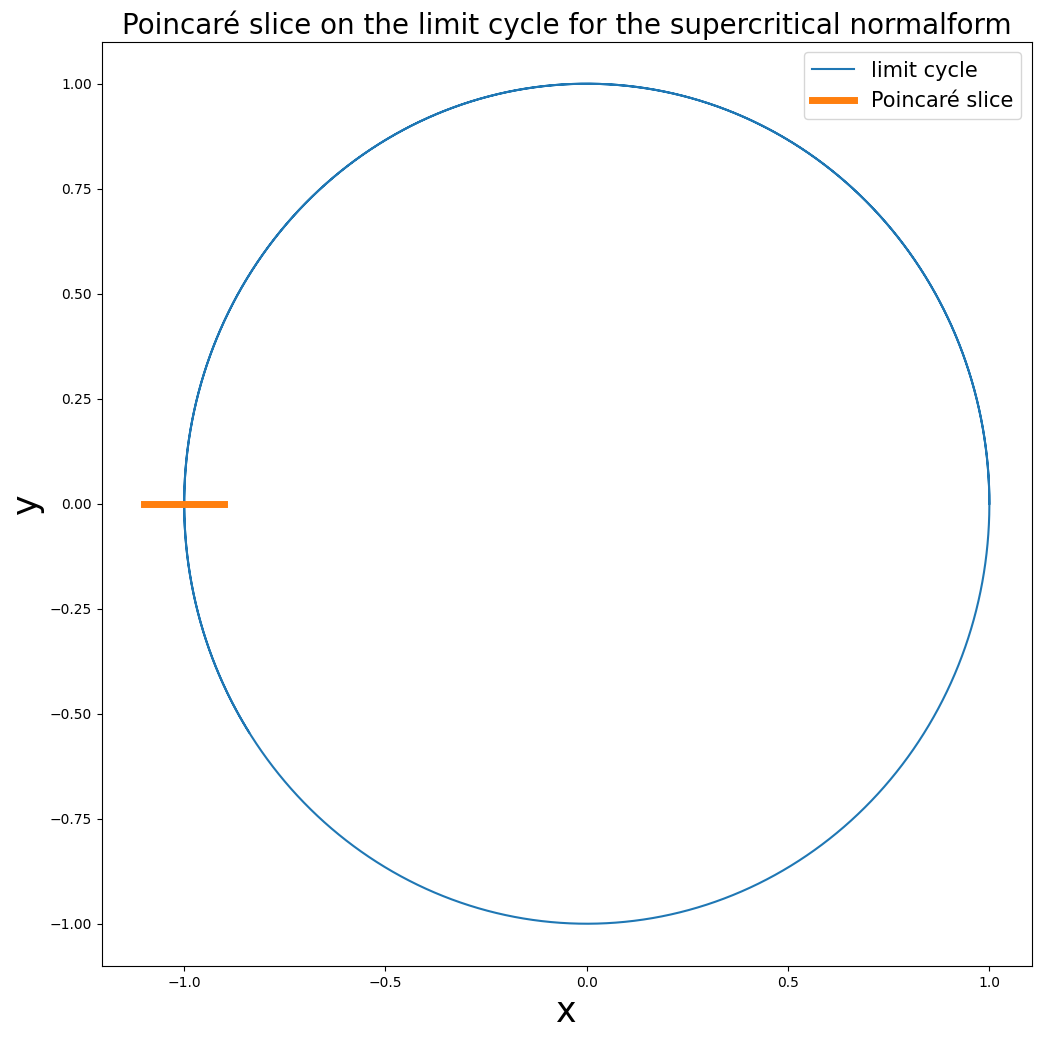

In [4]:
plt.plot(limx,limy, label = "limit cycle")
plt.xlabel('x',fontsize = 25)
plt.ylabel('y',fontsize = 25)
plt.plot([-1.1,-0.9],[0,0], linewidth = 5,label = "Poincaré slice")
plt.legend(fontsize = 15)
plt.title('Poincaré slice on the limit cycle for the supercritical normalform', fontsize = 20)


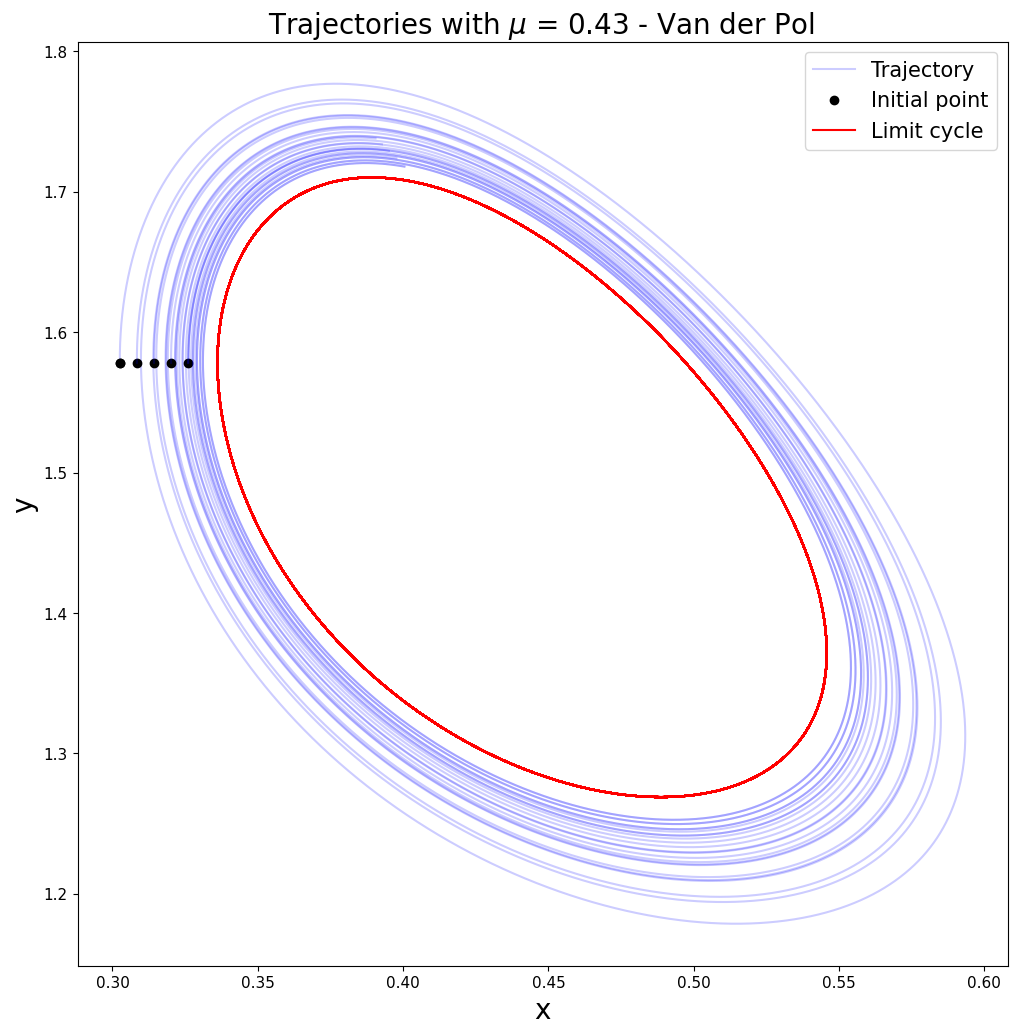

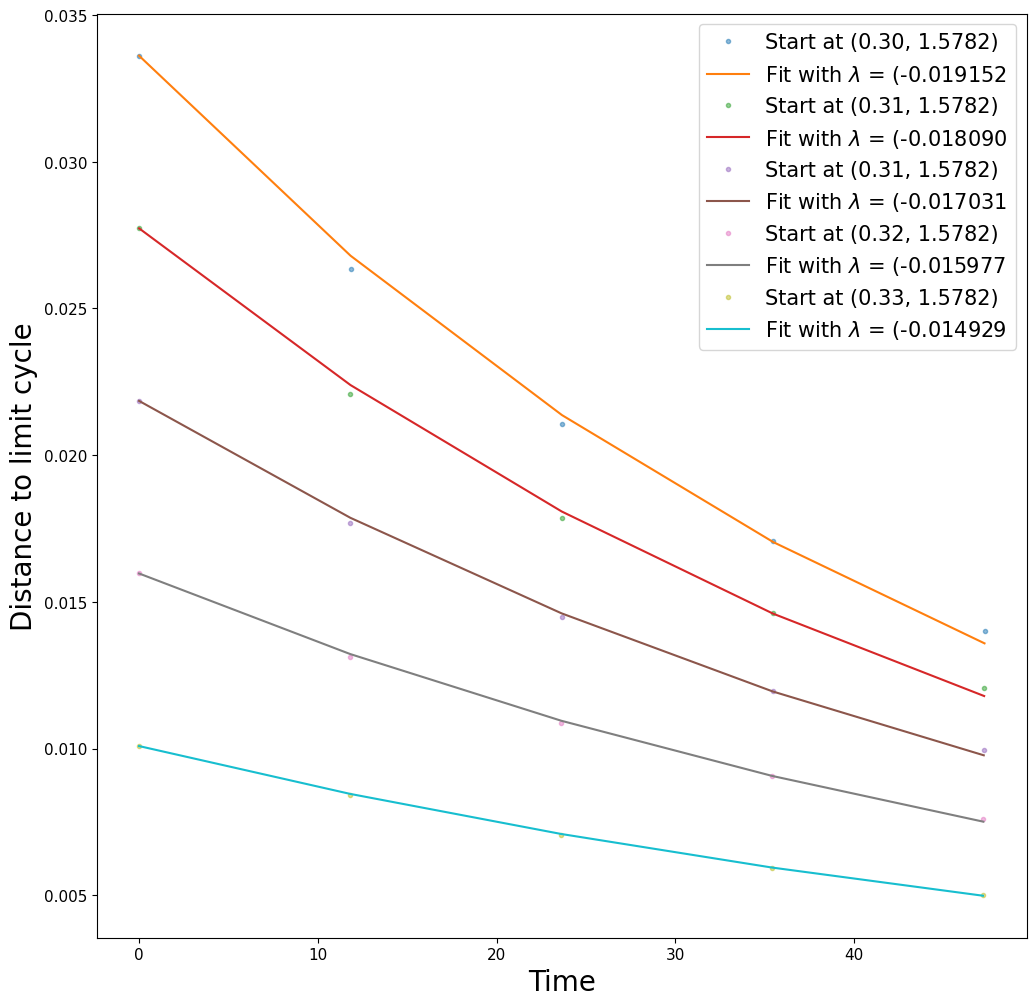

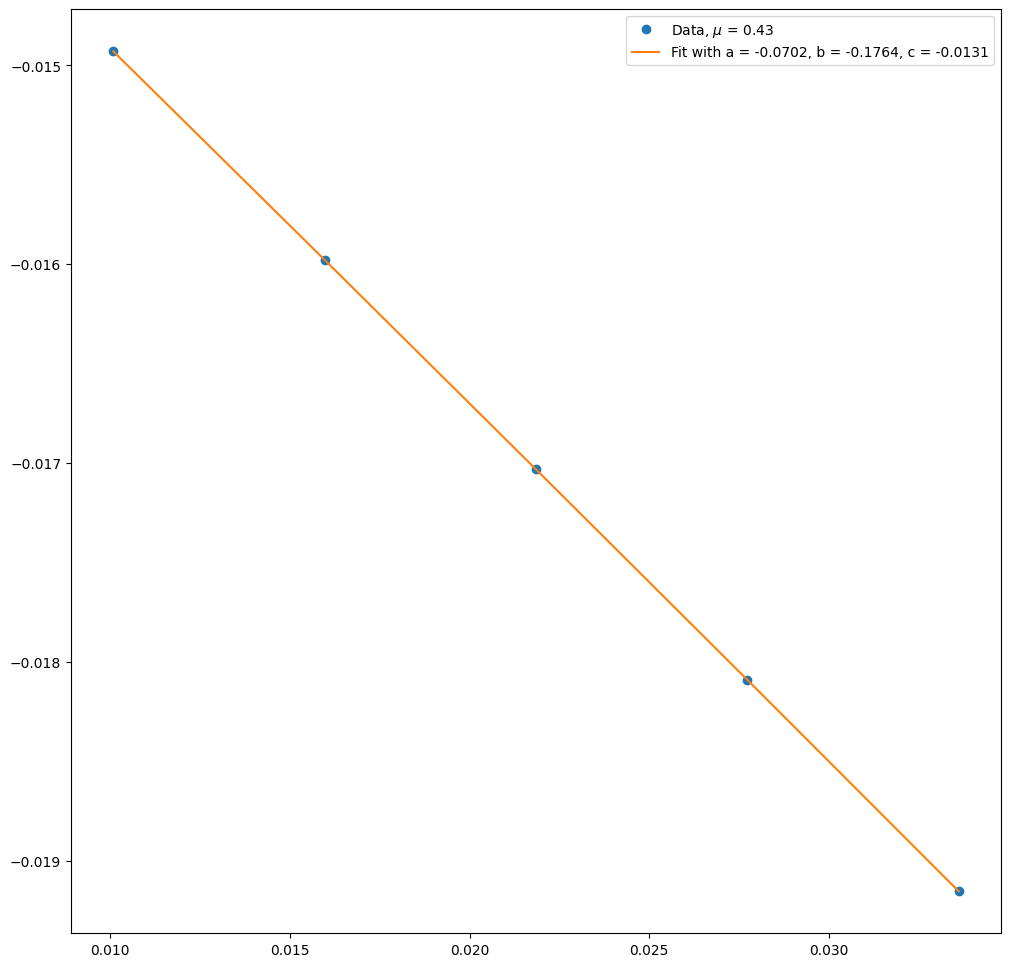

In [5]:
w = 0.1
#npoints = 200000
#dt = 0.0001
npoints = 50000
dt = 0.001#0.0005
lyapunovlist = []
linlist = []
quadlist = []
mu = 0.43
eiglist,dist0list = distance_eig(5,solution_supercrit_Cart,SelkovX,SelkovY,[mu,w],lb = 0.9,ub = 0.97,analytical_solution= False,distance_trad=False,plot = True, npoints = npoints, dt = dt)
popt2,_ = curve_fit(quadfit, dist0list,eiglist)
plt.show()
plt.plot(dist0list, eiglist, 'o', label = f"Data, $\mu$ = {mu} ")
plt.plot(dist0list, quadfit(dist0list, *popt2), '-', label = f"Fit with a = {popt2[0]:.4f}, b = {popt2[1]:.4f}, c = {popt2[2]:.4f}")
plt.legend()
plt.show()

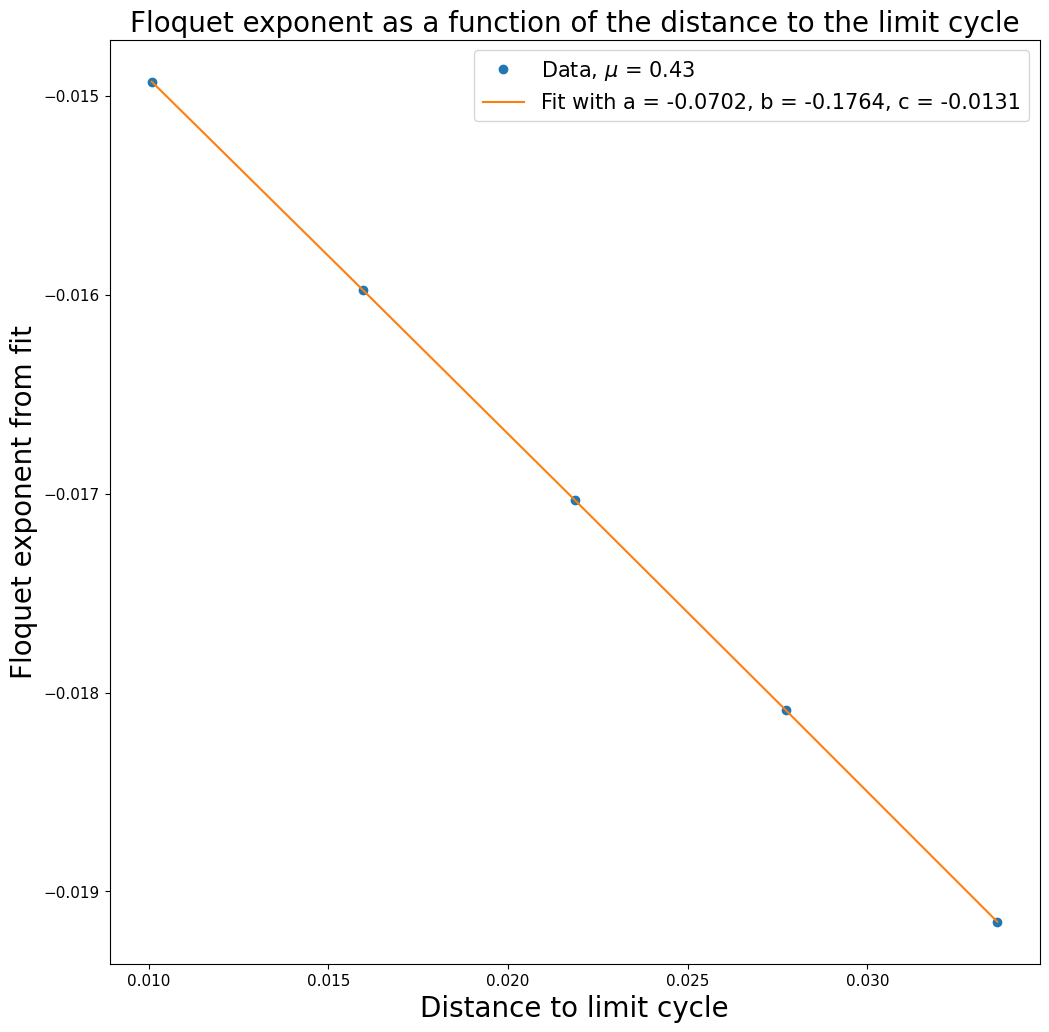

In [6]:
plt.plot(dist0list, eiglist, 'o', label = f"Data, $\mu$ = {mu} ")
plt.plot(dist0list, quadfit(dist0list, *popt2), '-', label = f"Fit with a = {popt2[0]:.4f}, b = {popt2[1]:.4f}, c = {popt2[2]:.4f}")
plt.legend(fontsize = 15)
plt.title('Floquet exponent as a function of the distance to the limit cycle', fontsize = 20)
plt.xlabel('Distance to limit cycle', fontsize = 20)
plt.ylabel('Floquet exponent from fit', fontsize = 20)
plt.xticks(fontsize=11) 
plt.yticks(fontsize=11)
plt.show()


-1.0
-0.9487179487179487
-0.8974358974358975
-0.8461538461538461
-0.7948717948717949
-0.7435897435897436
-0.6923076923076923
-0.641025641025641
-0.5897435897435898
-0.5384615384615385
-0.4871794871794872
-0.4358974358974359
-0.3846153846153846
-0.33333333333333337
-0.28205128205128205
-0.23076923076923084
-0.17948717948717952
-0.1282051282051282
-0.07692307692307698
-0.02564102564102566
0.02564102564102555
0.07692307692307687
0.1282051282051282
0.17948717948717952
0.23076923076923084
0.28205128205128194
0.33333333333333326
0.3846153846153846
0.4358974358974359
0.4871794871794872
0.5384615384615383
0.5897435897435896
0.641025641025641
0.6923076923076923
0.7435897435897436
0.7948717948717947
0.846153846153846
0.8974358974358974
0.9487179487179487
1.0


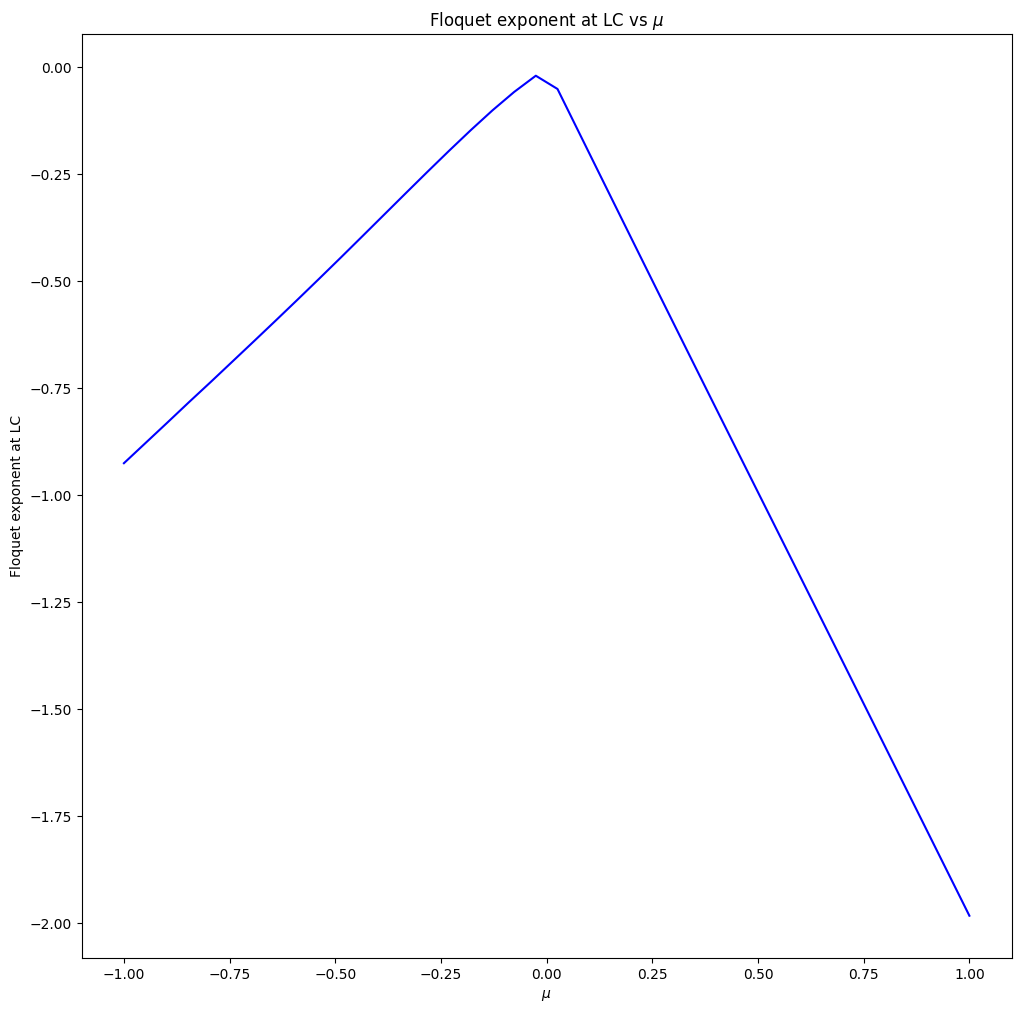

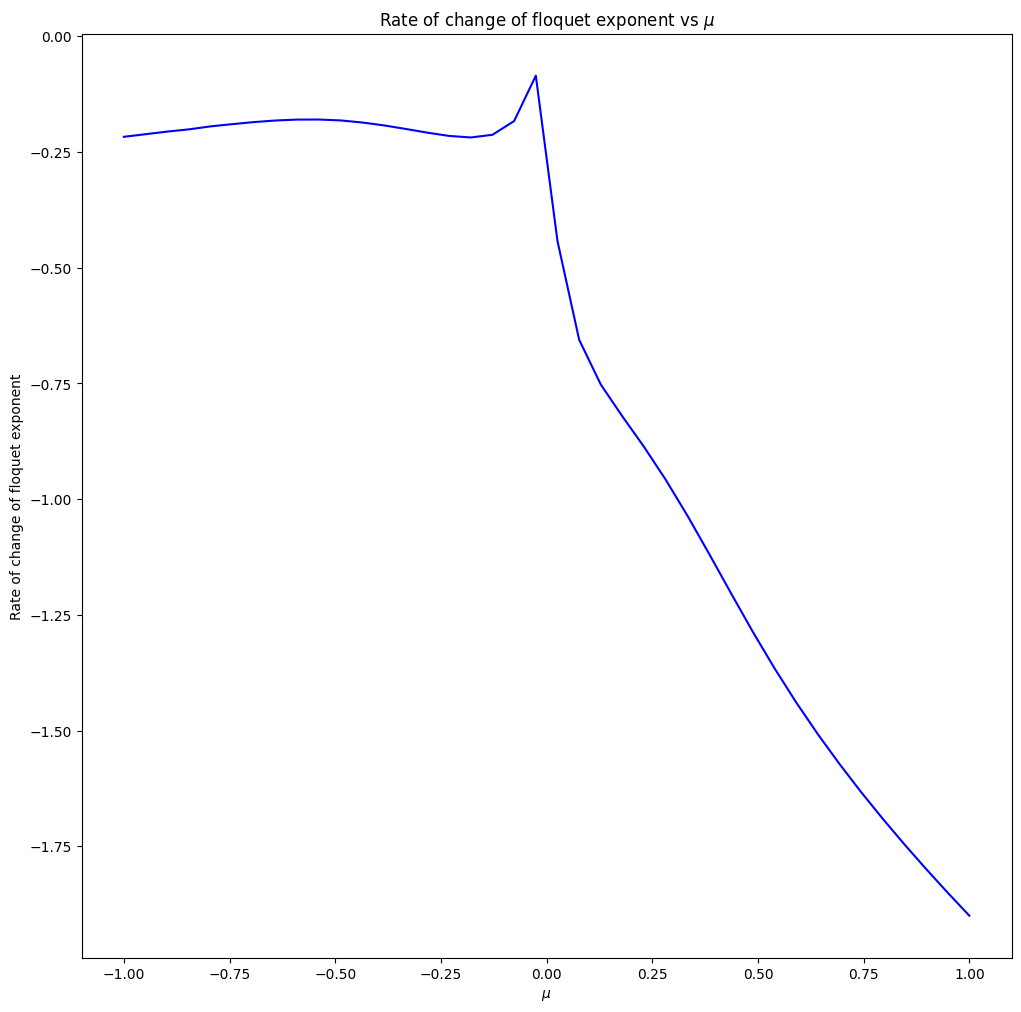

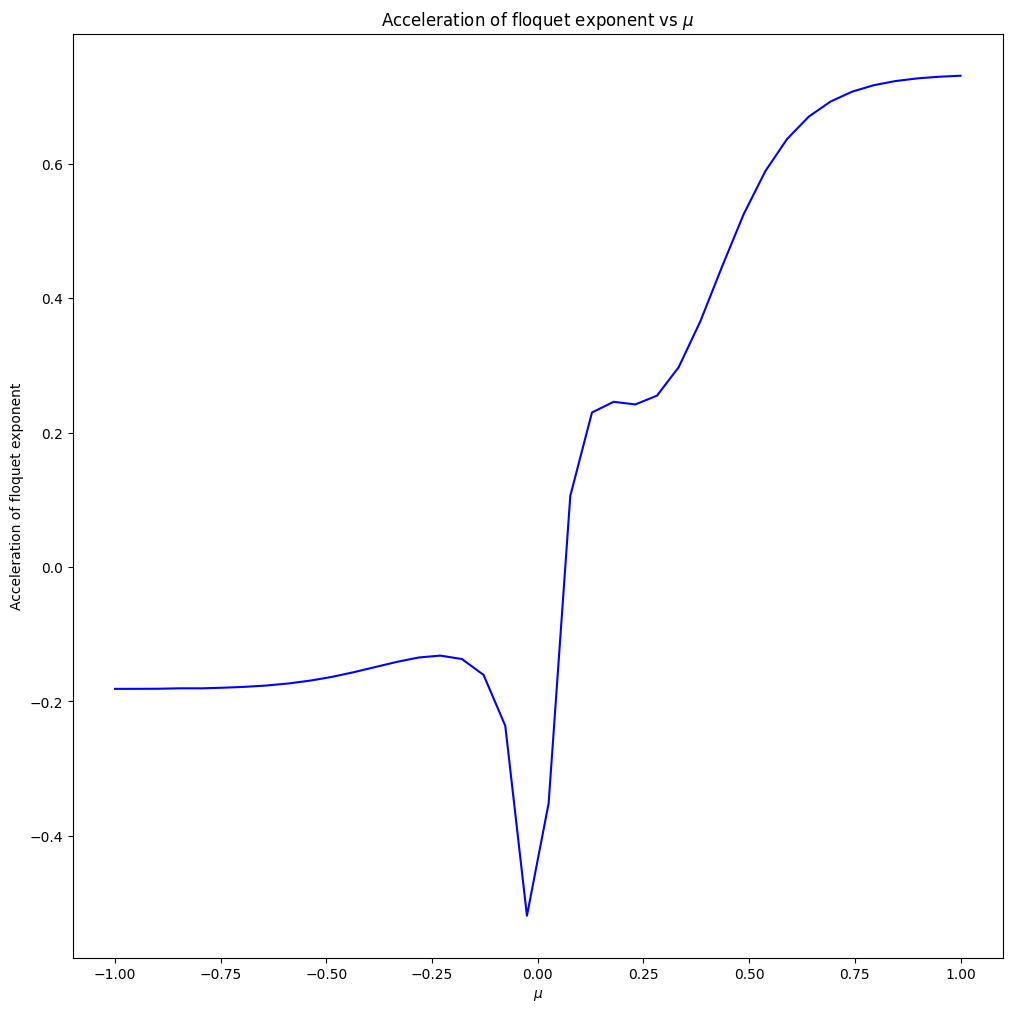

In [18]:
#n = 0
n = -1#0.4201#0.00005 #0.0001
m =  1#0.789#0.001
mulist = list(np.linspace(n, m, 40))

w = 0.1
#npoints = 200000
#dt = 0.0001
npoints = 5000 #10000
dt = 0.001
lyapunovlist = []
linlist = []
quadlist = []
for mu in mulist:
    #eiglist,dist0list = distance_eig(5,'none',SelkovX,SelkovY,[mu,w],lb = 0.8,ub = 0.92,distance_trad=False,plot = False, npoints = npoints, dt = dt)
    eiglist,dist0list = distance_eig(4,solution_supercrit_Cart,x_supercrit,y_supercrit,[mu,w],lb = 1.05,ub = 1.15,analytical_solution= True,distance_trad=True,plot = False, npoints = npoints, dt = dt)
    popt2,_ = curve_fit(quadfit, dist0list,eiglist)
    lyapunovlist.append(popt2[2])
    linlist.append(popt2[1])
    quadlist.append(popt2[0])
    print(mu)
plot = True
if plot:
    plt.plot(mulist,lyapunovlist, color = "blue")
    plt.xlabel('$\mu$')
    plt.ylabel('Floquet exponent at LC')
    plt.title('Floquet exponent at LC vs $\mu$')
    plt.show()

    plt.plot(mulist,linlist , color = "blue")
    plt.xlabel('$\mu$')
    plt.ylabel('Rate of change of floquet exponent')
    plt.title('Rate of change of floquet exponent vs $\mu$')
    plt.show()

    plt.plot(mulist,quadlist, color = "blue")   
    plt.xlabel('$\mu$')
    plt.ylabel('Acceleration of floquet exponent')
    plt.title('Acceleration of floquet exponent vs $\mu$')
    plt.show()  
plt.show()
#plt.plot(dist,eig)
#What happens is, it creates (the first value of distance_eig) random start points for the trajectory for each mu, then calculates the distance, finds the floquet exponent and fits the floquet exponent vs distance to a quadratic function.
#Then it takes the coefficient of the linear term and the quadratic term and plots them against mu. 
#The linear term is the rate of change of the floquet exponent and the quadratic term is the acceleration of the floquet exponent.

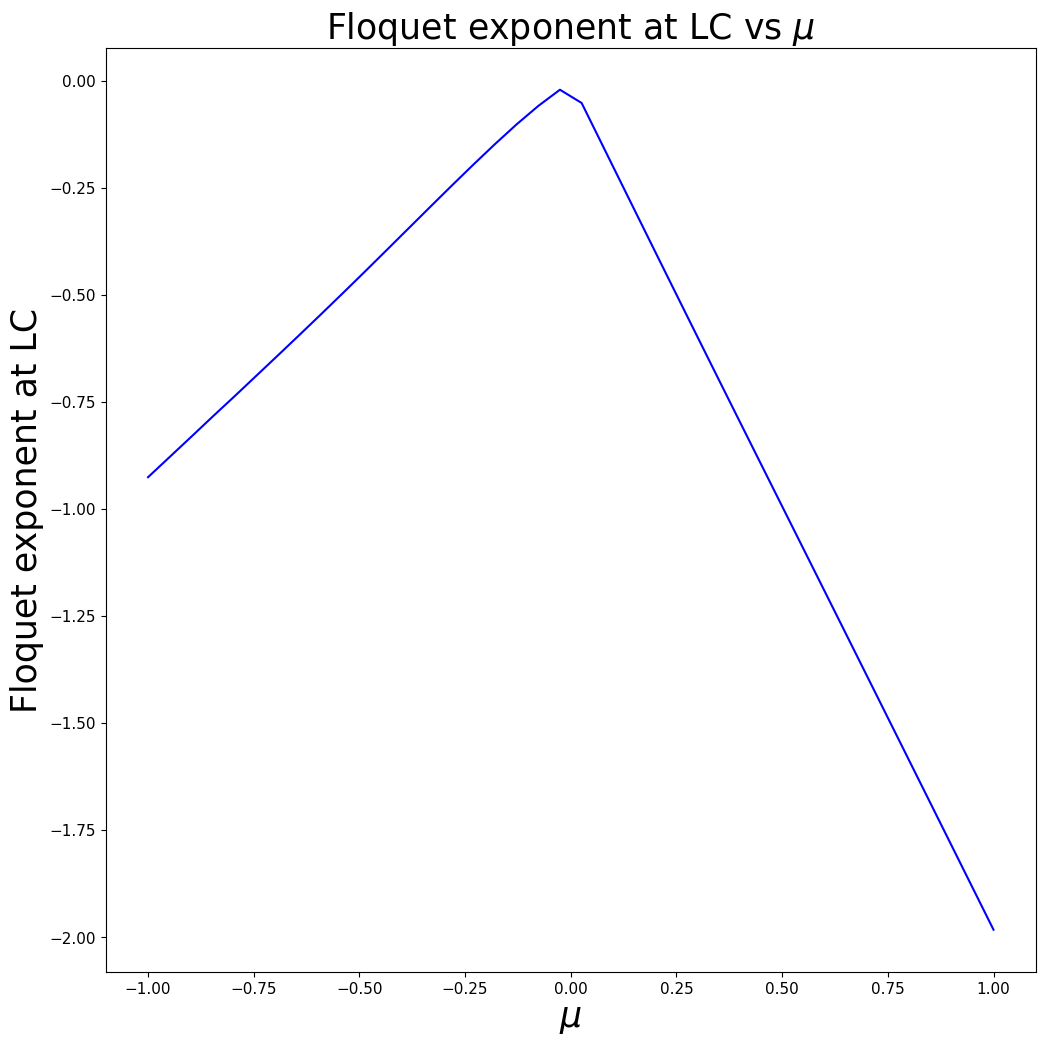

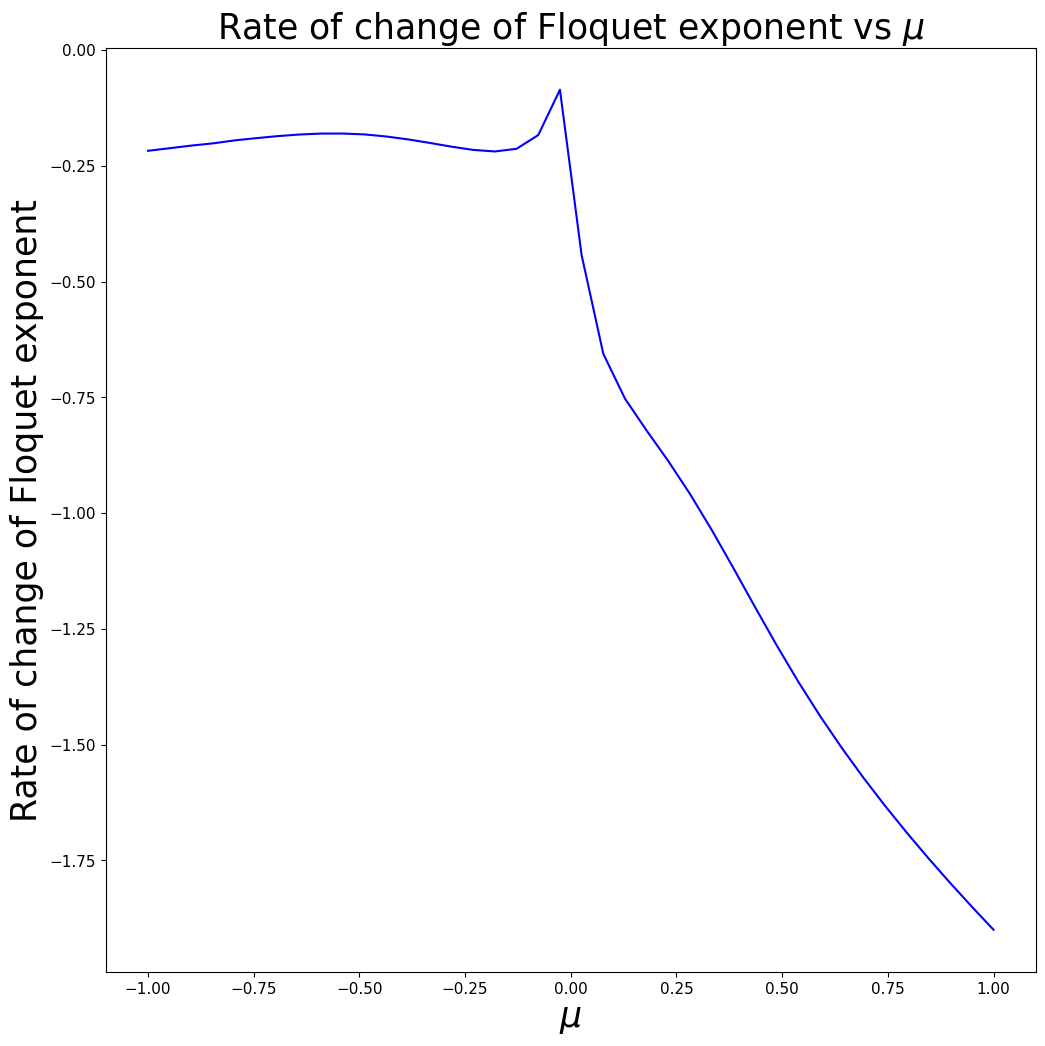

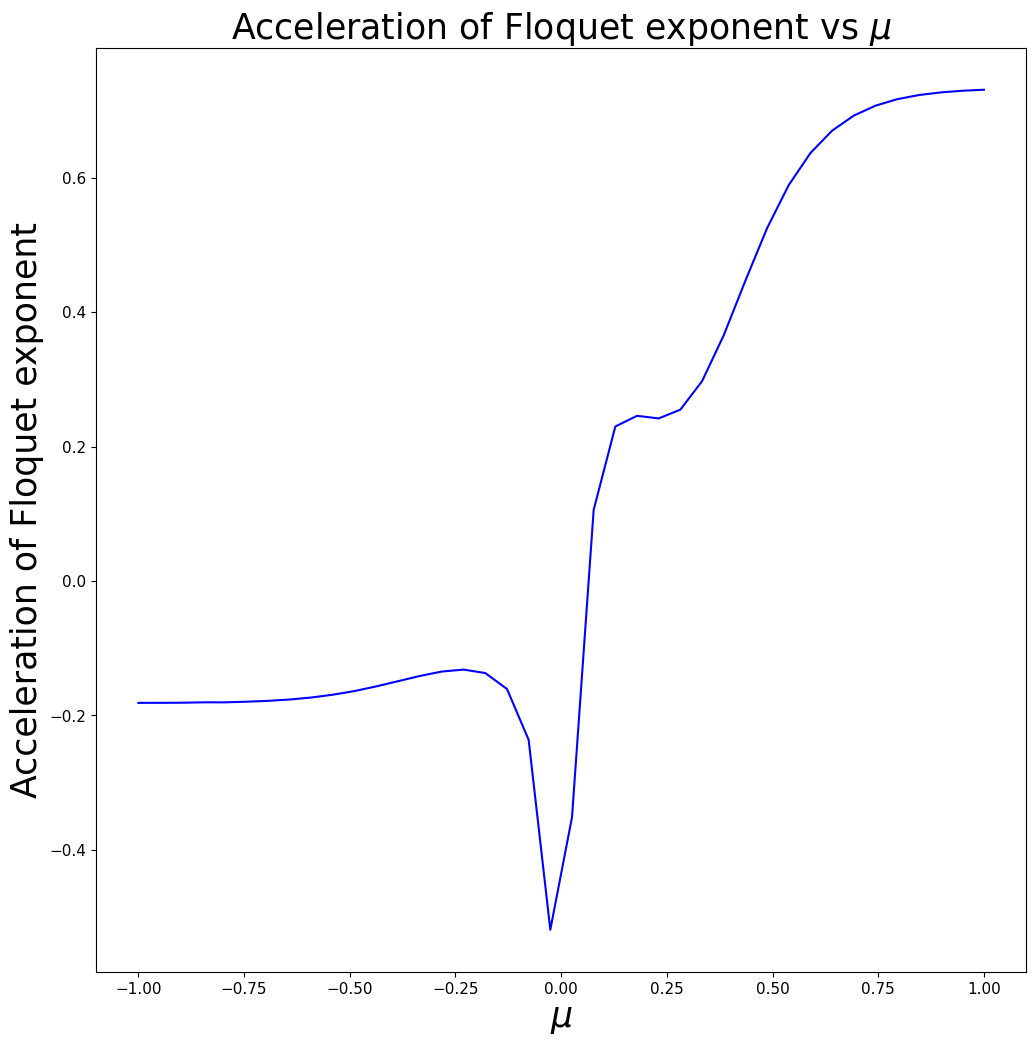

In [19]:
plot = True
if plot:
    plt.plot(mulist,lyapunovlist, color = "blue")
    plt.xlabel('$\mu$',fontsize = 25)
    plt.ylabel('Floquet exponent at LC',fontsize = 25)
    plt.title('Floquet exponent at LC vs $\mu$',fontsize = 25)
    plt.xticks(fontsize=11) 
    plt.yticks(fontsize=11)
    plt.show()

    plt.plot(mulist,linlist , color = "blue")
    plt.xlabel('$\mu$',fontsize = 25)
    plt.ylabel('Rate of change of Floquet exponent',fontsize = 25)
    plt.title('Rate of change of Floquet exponent vs $\mu$',fontsize = 25)
    plt.xticks(fontsize=11) 
    plt.yticks(fontsize=11)
    plt.show()

    plt.plot(mulist,quadlist, color = "blue")   
    plt.xlabel('$\mu$',fontsize = 25)
    plt.ylabel('Acceleration of Floquet exponent',fontsize = 25)
    plt.title('Acceleration of Floquet exponent vs $\mu$',fontsize = 25)
    plt.xticks(fontsize=11) 
    plt.yticks(fontsize=11)
    plt.show()  
plt.show()


In [15]:
print(lyapunovlist[0])

-0.9252773262622093


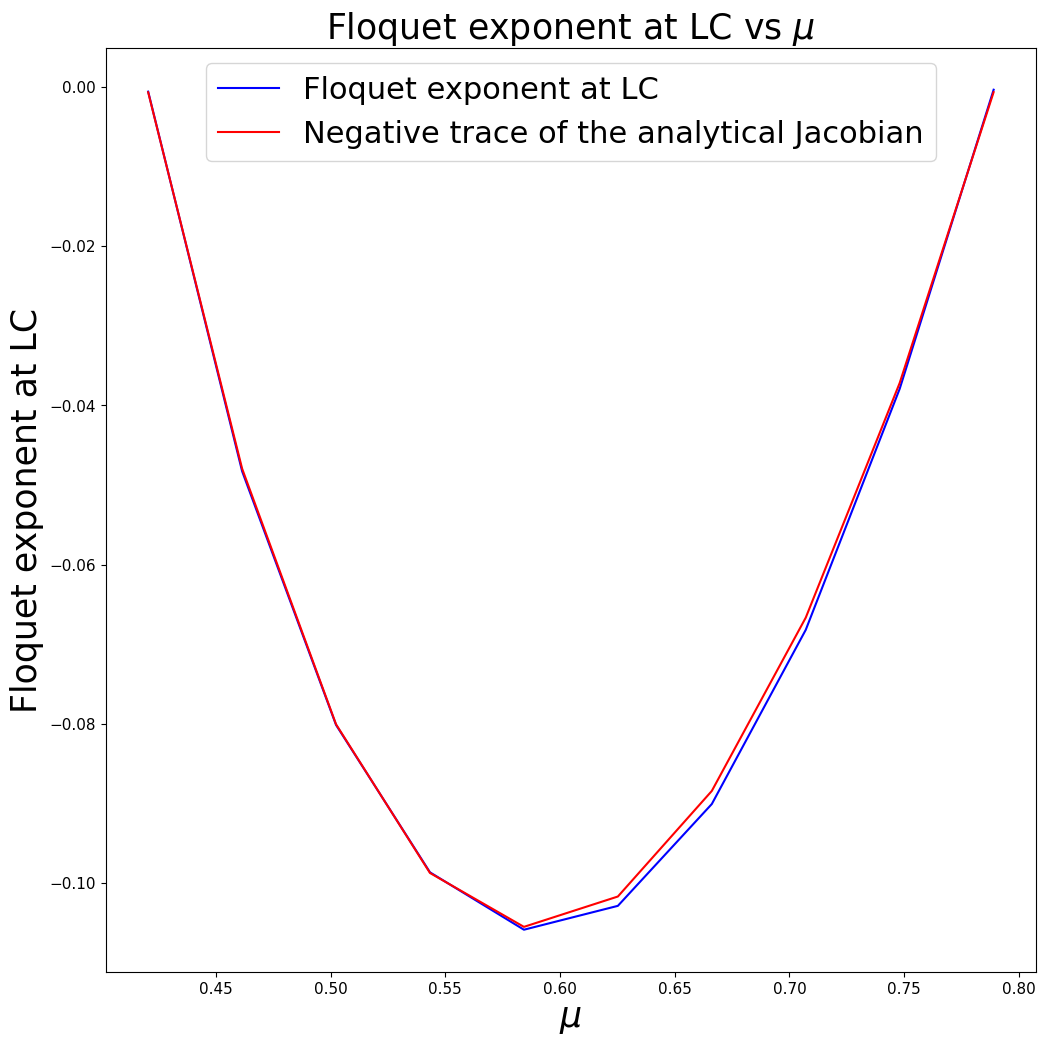

In [7]:
def test(x,a=0.1):
    #return -2*x
    #return -x
    return -(-1+ 2*x**2 / (a+ x**2) - a - x**2)
plt.plot(mulist,lyapunovlist, color = "blue", label = "Floquet exponent at LC")
plt.plot(mulist,test(np.array(mulist)), color = "red", label ='Negative trace of the analytical Jacobian')
plt.xlabel('$\mu$',fontsize = 25)
plt.ylabel('Floquet exponent at LC',fontsize = 25)
plt.title('Floquet exponent at LC vs $\mu$',fontsize = 25)
plt.xticks(fontsize=11) 
plt.yticks(fontsize=11)
plt.legend(fontsize = 22)
plt.show()

In [108]:
filenamex = []
filenames = []
stagger = [0,1,2,3,4]

for j,i in enumerate(quadlist[1:]):
    plt.plot(mulist[j+1],i, 'o', color = 'red', label = f"Current $\mu$ = {mulist[j]:.6f}")
    plt.plot(mulist,quadlist, color = "blue", label = "Acceleration of floquet exponent")   
    plt.xlabel('mu')
    plt.ylabel('Acceleration of floquet exponent')
    plt.title('Acceleration of floquet exponent vs $\mu$')
    plt.legend(loc = 'upper right')
    if i == np.min(quadlist):
        #filenamex = f'temp_plot_{i}_x_minimum.png'
        #plt.savefig(filenamex, bbox_inches='tight', pad_inches=0.1)
        #filenames.append(filenamex)
        for k in stagger:
            plt.plot(mulist[j+1],i, 'o', color = 'green', label = f"Minimum $\mu$ = {mulist[j]:.6f}")
            plt.axvline(mulist[j+1], color = 'green', label = f"Minimum value = {i:.6f}")
            filenamex = f'temp_plot_{i}_{k}_x_minimum.png'
            plt.savefig(filenamex, bbox_inches='tight', pad_inches=0.1)  
            filenames.append(filenamex)
    else:
        filenamex = f'temp_plot_{i}_x.png'
        plt.savefig(filenamex, bbox_inches = 'tight', pad_inches = 0.1)
        filenames.append(filenamex)
    plt.close()
make_gif(filenames,'SCN_Acc',display_length=2)


In [ ]:
#n = 0
n = 0.0001
m = 0.01
mulist = list(np.linspace(n, m, 20))

w = 1
#npoints = 200000
#dt = 0.0001
npoints = 10000 #60000
dt = 0.005
lyapunovlist = []
linlist = []
quadlist = []
for mu in mulist:
    #LimX,LimY = LC_coords(1.75,1.75,VanX,VanY,[mu,w],converging_time=5000,runtime=4000,dt=dt,dt_conv=0.05)
    eiglist,dist0list = distance_eig(4,'none',VanX,VanY,[mu,w],lb = 2.1,ub = 2.45,distance_trad=False,plot = False, npoints = npoints, dt = dt)
    popt2,_ = curve_fit(quadfit, dist0list,eiglist)
    lyapunovlist.append(popt2[2])
    linlist.append(popt2[1])
    quadlist.append(popt2[0])
    print(mu)
plot = True
if plot:
    plt.plot(mulist,lyapunovlist, color = "blue")
    plt.xlabel('mu')
    plt.ylabel('Floquet exponent at LC')
    plt.title('Floquet exponent at LC vs mu')
    plt.show()

    plt.plot(mulist,linlist , color = "blue")
    plt.xlabel('mu')
    plt.ylabel('Rate of change of floquet exponent')
    plt.title('Rate of change of floquet exponent vs mu')
    plt.show()

    plt.plot(mulist,quadlist, color = "blue")   
    plt.xlabel('mu')
    plt.ylabel('Acceleration of floquet exponent')
    plt.title('Acceleration of floquet exponent vs mu')
    plt.show()
plt.show()
#plt.plot(dist,eig)
#What happens is, it creates (the first value of distance_eig) random start points for the trajectory for each mu, then calculates the distance, finds the floquet exponent and fits the floquet exponent vs distance to a quadratic function.
#Then it takes the coefficient of the linear term and the quadratic term and plots them against mu. 
#The linear term is the rate of change of the floquet exponent and the quadratic term is the acceleration of the floquet exponent.

In [ ]:
#mu = 0.4
mulist = 0.42#mulist = np.linspace(0.42,0.75,5)
w = 0.1
npoints = 80000
dt = 0.0005
for mu in mulist:
    eig,dist = distance_eig(5,'none',SelkovX,SelkovY,[mu,w],lb = 0.95,ub = 0.97,distance_trad=False,plot = False, npoints = npoints, dt = dt)
    plt.show()
    plt.plot(dist,eig,'o')
    popt2,_ = curve_fit(quadfit, dist,eig)
    plt.plot(dist,quadfit(dist,*popt2),'-',label = f"Fit with a = {popt2[0]:.4f}, b = {popt2[1]:.4f}, c = {popt2[2]:.4f}")
    plt.xlabel('distance to LC')
    plt.ylabel('Eigenvalues')
    plt.legend()
    plt.show()
    